# Liesel-GAM Demo Notebook

## Setup and Imports

In [1]:
import jax.numpy as jnp
import liesel.goose as gs
import liesel.model as lsl
import numpy as np
import pandas as pd
import plotnine as p9
import tensorflow_probability.substrates.jax.distributions as tfd

import liesel_gam as gam

In [2]:
def gen_tp_data(n=400, noise_sd=0.3, grid=False, seed=1):
    """
    Generate test data for tensor-product smooths.

    Parameters
    ----------
    n : int
        Number of samples (if grid=False).
    noise_sd : float
        Standard deviation of Gaussian noise.
    grid : bool
        If True, generate approximately n points on a regular grid.
        If False, generate random design points.
    seed : int
        Random seed.

    Returns
    -------
    pandas.DataFrame with columns: x, y, eta (signal), z (noisy response)
    """
    rng = np.random.default_rng(seed)

    # --- Design ----
    if grid:
        m = int(np.ceil(np.sqrt(n)))
        xs = np.linspace(0, 1, m)
        ys = np.linspace(0, 1, m)
        x, y = np.meshgrid(xs, ys, indexing="xy")
        x = x.ravel()
        y = y.ravel()
    else:
        x = rng.uniform(0, 1, n)
        y = rng.uniform(0, 1, n)

    # --- True non-separable smooth ----
    def f_true(x, y):
        return (
            1.5 * np.sin(2 * np.pi * x) * np.cos(3 * np.pi * y)
            + 0.8 * x * y
            + 2.0 * np.exp(-(((x - 0.65) ** 2) / 0.01 + ((y - 0.35) ** 2) / 0.06))
        )

    eta = f_true(x, y)
    z = eta + rng.normal(scale=noise_sd, size=len(eta))

    return pd.DataFrame({"x": x, "y": y, "eta": eta, "z": z})

In [3]:
df = gen_tp_data(n=600, noise_sd=0.25, grid=False, seed=42)
print(df.head())

          x         y       eta         z
0  0.773956  0.477506  0.935849  0.689560
1  0.438878  0.761433  0.621075  0.405865
2  0.858598  0.903328  1.334100  1.948456
3  0.697368  0.720696 -0.674870 -0.224435
4  0.094177  0.963211 -0.714339 -0.817277


In [4]:
df_grid = gen_tp_data(n=5000, grid=True)

In [5]:
df_grid

,x,y,eta,z
0,0.000000,0.0,1.162528e-19,0.103675
1,0.014286,0.0,1.344590e-01,0.380944
2,0.028571,0.0,2.678353e-01,0.366966
3,0.042857,0.0,3.990553e-01,0.008108
4,0.057143,0.0,5.270622e-01,0.798669
...,...,...,...,...
5036,0.942857,1.0,1.281348e+00,1.076909
5037,0.957143,1.0,1.164770e+00,1.171729
5038,0.971429,1.0,1.044978e+00,1.027468
5039,0.985714,1.0,9.230304e-01,0.818835


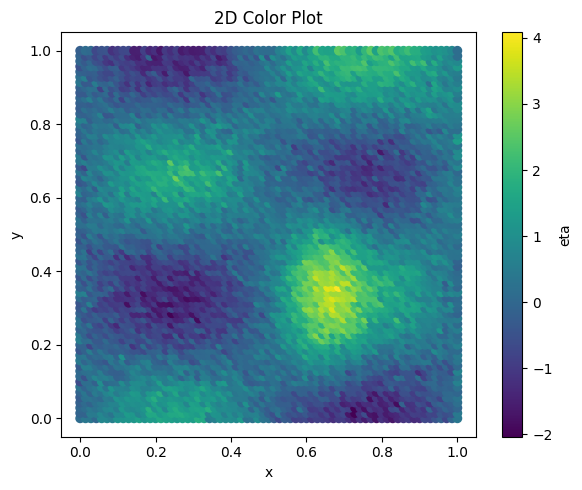

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.scatter(df_grid["x"], df_grid["y"], c=df_grid["z"])
plt.xlabel("x")
plt.ylabel("y")
plt.title("2D Color Plot")
plt.colorbar(label="eta")
plt.tight_layout()
plt.show()

## Model Definition

### Setup response model

In [7]:
loc = gam.AdditivePredictor("$\\mu$")
scale = gam.AdditivePredictor("$\\sigma$", inv_link=jnp.exp)


z = lsl.Var.new_obs(
    value=df.z.to_numpy(),
    distribution=lsl.Dist(tfd.Normal, loc=loc, scale=scale),
    name="z",
)

In [8]:
tb = gam.TermBuilder.from_df(df)

In [9]:
loc += tb.te("x", "y", bs=("ts", "cp"))

Warning message:
In smooth.construct.tensor.smooth.spec(object, dk$data, dk$knots) :
  reparameterization unstable for margin: not done
Warning message:
In smooth.construct.tensor.smooth.spec(object, dk$data, dk$knots) :
  reparameterization unstable for margin: not done


### Build and plot model

liesel.model.model - INFO - Converted dtype of Value(name="z_value").value


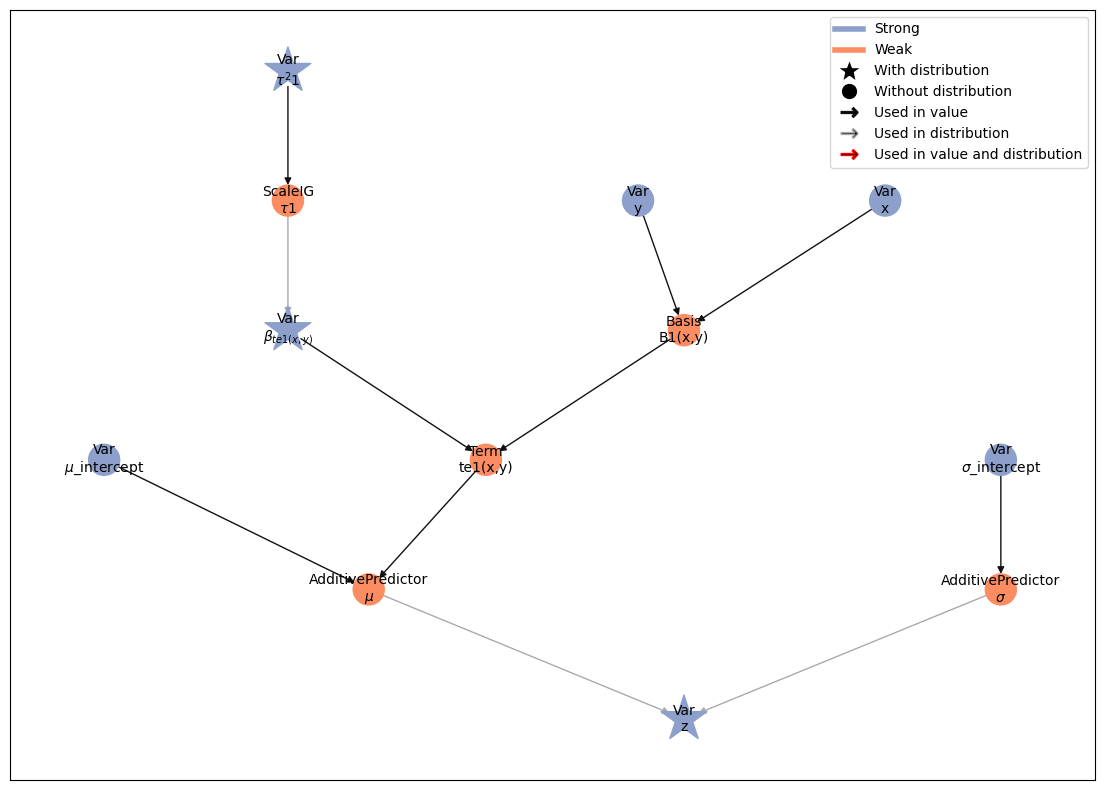

In [10]:
model = lsl.Model([z])
model.plot_vars()

## Run MCMC

Since we used the `inference` arguments to specify MCMC kernels for all parameters above,
we can quickly set up the MCMC engine with `gs.LieselMCMC` (new in v0.4.0).

In [11]:
eb = gs.LieselMCMC(model).get_engine_builder(
    seed=1, num_chains=4
)  # New in liesel v0.4.0

eb.set_epochs(
    gs.stan_epochs(
        warmup_duration=1000,
        posterior_duration=1000,
        init_duration=200,
        term_duration=200,
        thinning_posterior=5,
    )
)
engine = eb.build()
engine.sample_all_epochs()
results = engine.get_results()

liesel.goose.builder - WARNING - No jitter functions provided for position keys '$\\sigma$_intercept', '$\\mu$_intercept', '$\\beta_{te1(x,y)}$', '$\\tau^2$1'. The initial values for these keys won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done
liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 200 transitions, 25 jitted together
100%|██████████████████████████████████████████| 8/8 [00:02<00:00,  3.20chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
100%|████████████████████████████████████████| 1/1 [00:00<00:00, 1001.03chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 50 transitions, 25 jitted together
100%|████████████████████████████████████████| 2/2 [00:00<00:00, 1207.69chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Start

### MCMC summary

In [12]:
summary = gs.Summary(results)
summary

Parameter summary:

                             kernel      mean        sd    q_0.05     q_0.5  \
parameter          index                                                      
$\beta_{te1(x,y)}$ (0,)   kernel_02 -1.167446  0.425840 -1.836744 -1.171204   
                   (1,)   kernel_02  0.122887  0.412847 -0.543447  0.110818   
                   (2,)   kernel_02 -0.729213  0.455440 -1.494169 -0.720585   
                   (3,)   kernel_02 -0.381534  0.405200 -1.024641 -0.382684   
                   (4,)   kernel_02  0.122593  0.505657 -0.729583  0.146048   
...                             ...       ...       ...       ...       ...   
                   (61,)  kernel_02  0.093906  0.431748 -0.613449  0.082019   
                   (62,)  kernel_02  0.078011  0.439048 -0.635290  0.108367   
$\mu$_intercept    ()     kernel_01  0.361828  0.017932  0.332125  0.361363   
$\sigma$_intercept ()     kernel_00 -0.828666  0.030182 -0.878746 -0.829632   
$\tau^2$1          ()     kernel_03  1.623361  0.330117  1.154292  1.575723   

                            q_0.95  sample_size    ess_bulk    ess_tail  \
parameter          index                                                  
$\beta_{te1(x,y)}$ (0,)  -0.449672          800  226.256289  406.259594   
                   (1,)   0.836259          800  191.039484  484.679431   
                   (2,)   0.021394          800  170.129824  475.827564   
                   (3,)   0.267552          800  299.854913  602.407958   
                   (4,)   0.993908          800  272.976537  425.511709   
...                            ...          ...         ...         ...   
                   (61,)  0.803710          800  214.711723  345.571794   
                   (62,)  0.807169          800  293.712160  412.889738   
$\mu$_intercept    ()     0.390632          800  867.294288  771.236582   
$\sigma$_intercept ()    -0.780646          800  623.232241  719.159866   
$\tau^2$1          ()     2.230192          800  499.931778  620.782925   

                              rhat  
parameter          index            
$\beta_{te1(x,y)}$ (0,)   1.018903  
                   (1,)   1.016423  
                   (2,)   1.009500  
                   (3,)   1.009677  
                   (4,)   1.000970  
...                            ...  
                   (61,)  1.014263  
                   (62,)  1.027266  
$\mu$_intercept    ()     0.999489  
$\sigma$_intercept ()     1.002233  
$\tau^2$1          ()     1.007330  

[66 rows x 10 columns]

### MCMC trace plots

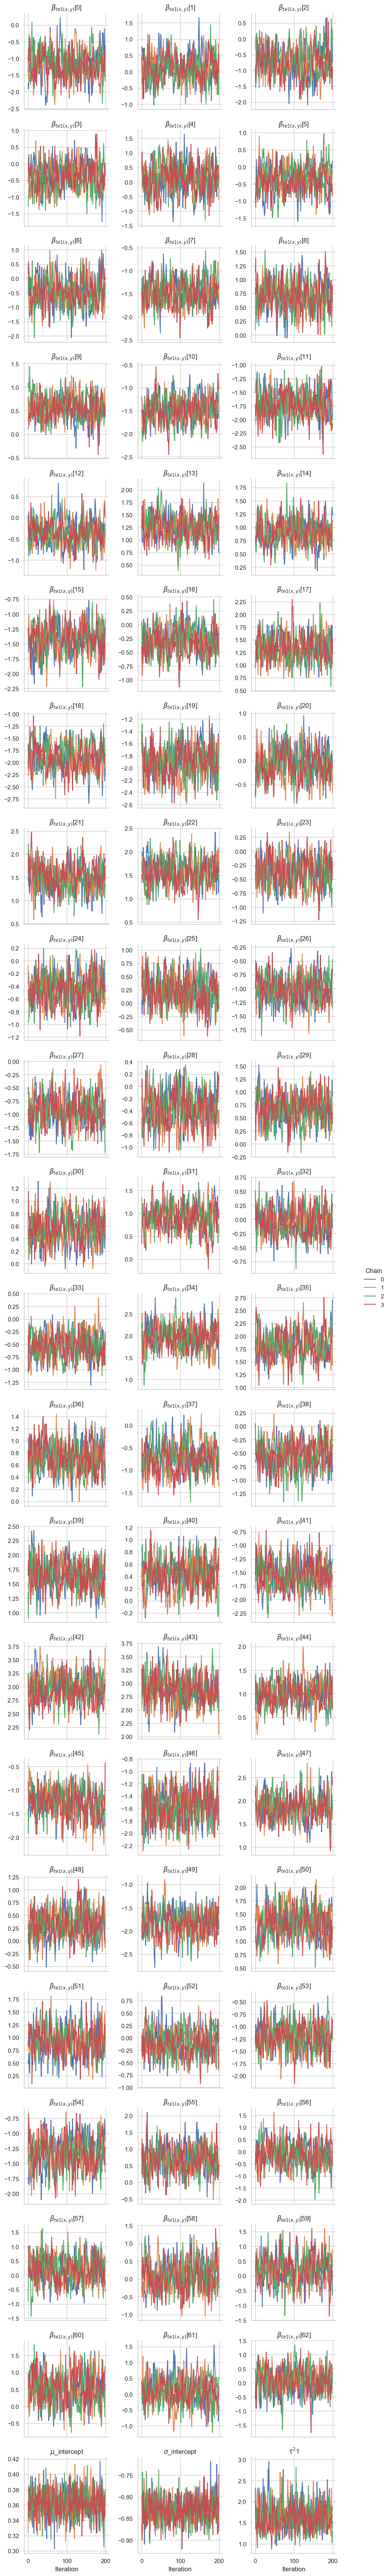

In [13]:
gs.plot_trace(results)

## Predictions

In [14]:
samples = results.get_posterior_samples()

### Predict variables at new x values

In [15]:
predictions = model.predict(  # new in liesel v0.4.0
    samples=samples,
    predict=["te1(x,y)", "$\\mu$"],
    newdata={"x": df_grid.x.to_numpy(), "y": df_grid.y.to_numpy()},
)

predictions_summary = (
    gs.SamplesSummary(predictions).to_dataframe().reset_index()
)  # new in liesel v0.4.0

In [16]:
predictions_summary["x"] = np.tile(df_grid.x.to_numpy(), len(predictions))
predictions_summary["y"] = np.tile(df_grid.y.to_numpy(), len(predictions))

In [17]:
predictions_summary.head()

,variable,var_fqn,var_index,sample_size,mean,var,sd,rhat,ess_bulk,ess_tail,mcse_mean,mcse_sd,q_0.05,q_0.5,q_0.95,hdi_low,hdi_high,x,y
0,$\mu$,$\mu$[0],"(0,)",800,-0.555179,0.062641,0.250283,1.008440,268.858451,499.001990,0.015319,0.008103,-0.961635,-0.552035,-0.157569,-0.963688,-0.164613,0.000000,0.0
1,$\mu$,$\mu$[1],"(1,)",800,-0.401607,0.046529,0.215707,1.010236,266.240983,565.300613,0.013287,0.006649,-0.742609,-0.398834,-0.057782,-0.741761,-0.057003,0.014286,0.0
2,$\mu$,$\mu$[2],"(2,)",800,-0.248594,0.034040,0.184499,1.012782,262.247775,539.691584,0.011422,0.005283,-0.548445,-0.246519,0.049445,-0.553630,0.032377,0.028571,0.0
3,$\mu$,$\mu$[3],"(3,)",800,-0.098007,0.025176,0.158671,1.016137,262.188064,532.504812,0.009823,0.004315,-0.362096,-0.100135,0.160619,-0.361933,0.161265,0.042857,0.0
4,$\mu$,$\mu$[4],"(4,)",800,0.047234,0.019754,0.140550,1.019786,269.383899,510.868138,0.008610,0.003777,-0.180310,0.040486,0.284136,-0.167375,0.293564,0.057143,0.0


### Plot fitted functions

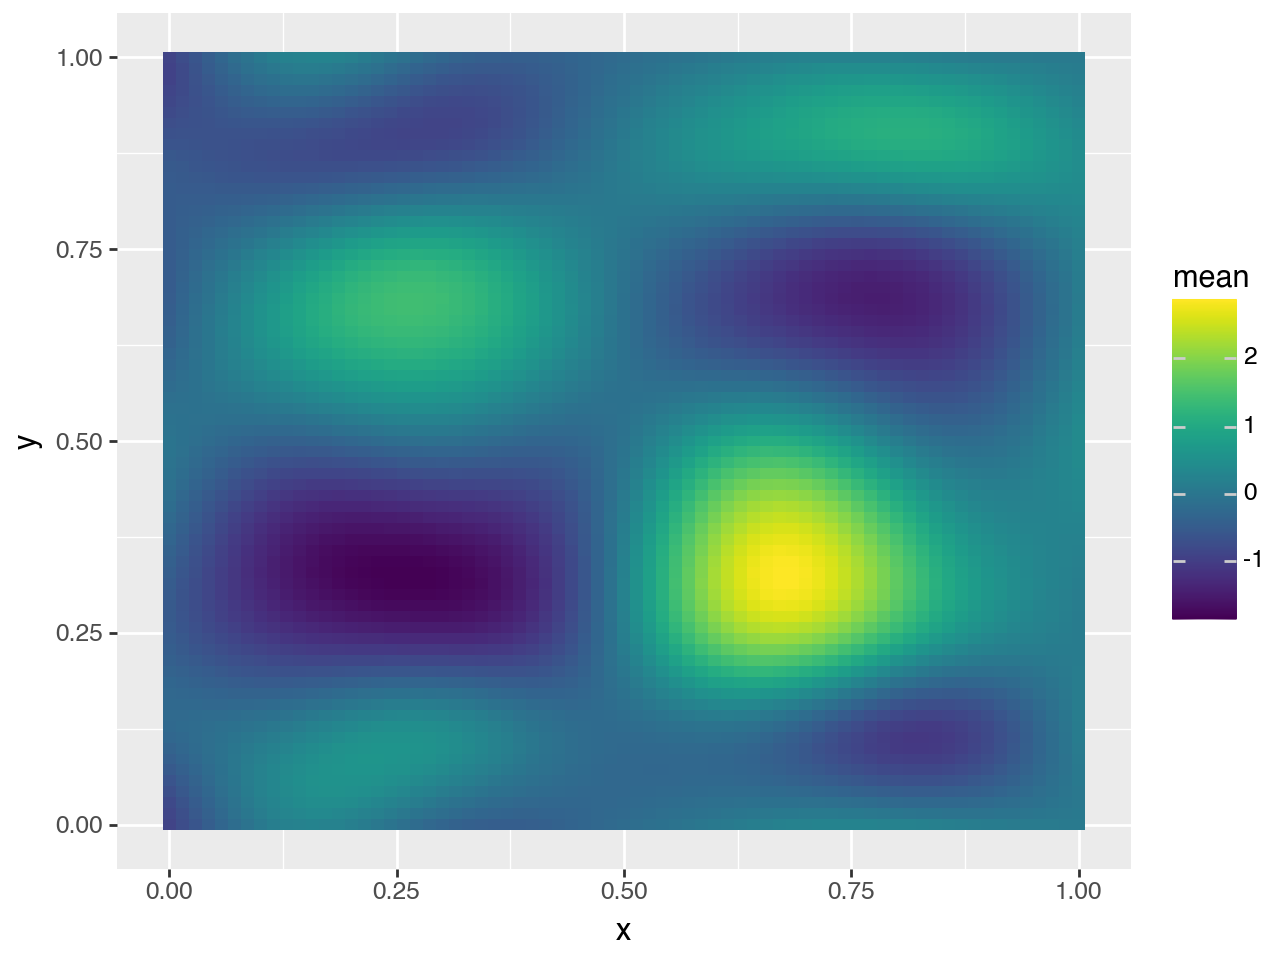

In [18]:
select = predictions_summary["variable"].isin(["te1(x,y)"])
(p9.ggplot(predictions_summary[select]) + p9.geom_tile(p9.aes("x", "y", fill="mean")))

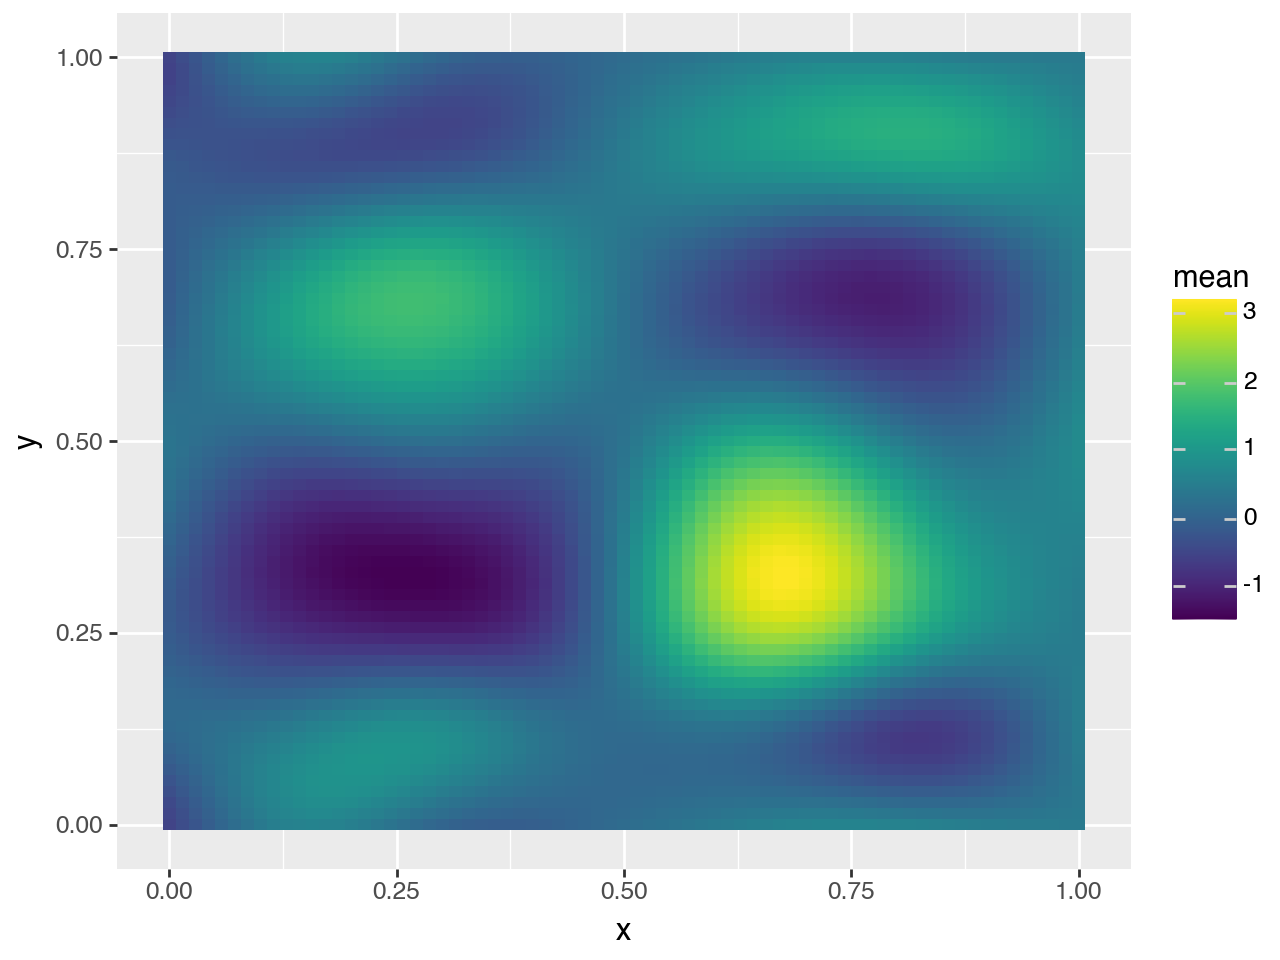

In [19]:
select = predictions_summary["variable"].isin(["$\\mu$"])
(p9.ggplot(predictions_summary[select]) + p9.geom_tile(p9.aes("x", "y", fill="mean")))

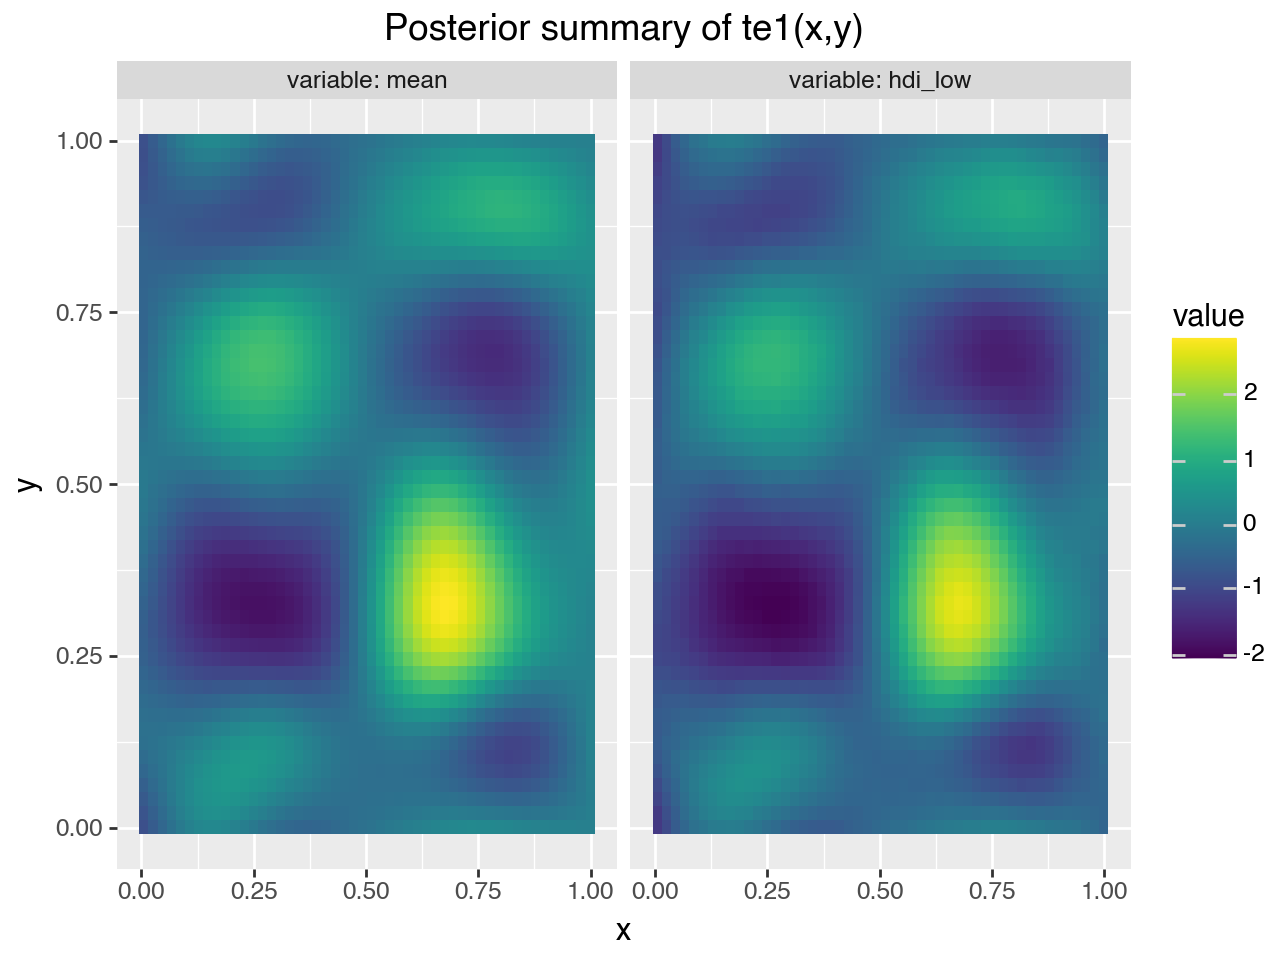

In [20]:
from liesel_gam.plots import plot_2d_smooth

plot_2d_smooth(
    loc.terms["te1(x,y)"], samples=samples, ngrid=50, plot_vars=["mean", "hdi_low"]
)